Simulaciones de base para comparación con métodos de redes neuronales en la predicción de precio de criptomonedas.

In [10]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Keras
from math import sqrt
from sklearn.metrics import mean_squared_error

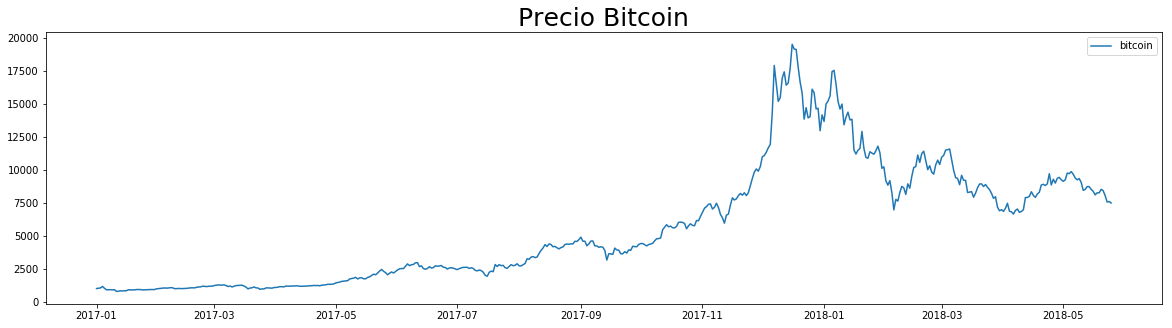

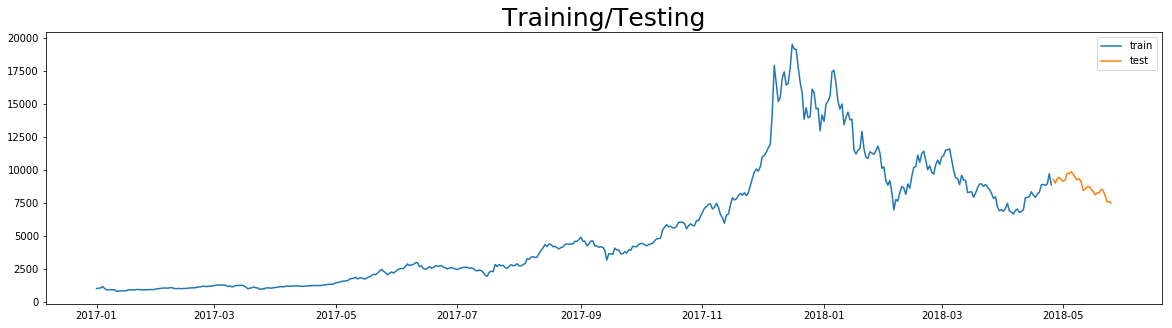

In [11]:
df = pd.read_csv('data/data.csv', usecols=['Date','bitcoin'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.figure(figsize=(20,5))
plt.title("Precio Bitcoin", fontsize=25)
plt.plot(df, label="bitcoin")
plt.legend()
plt.show()

test_size=30
window_size=1
dia_futuro=1

train = df[0:len(df)-test_size]
test  = df[len(df)-test_size:]
plt.figure(figsize=(20,5))
plt.title("Training/Testing", fontsize=25)
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()
plt.show()

Método "naive": el precio del día siguiente es igual al anterior -> y(t+1) = y(t)

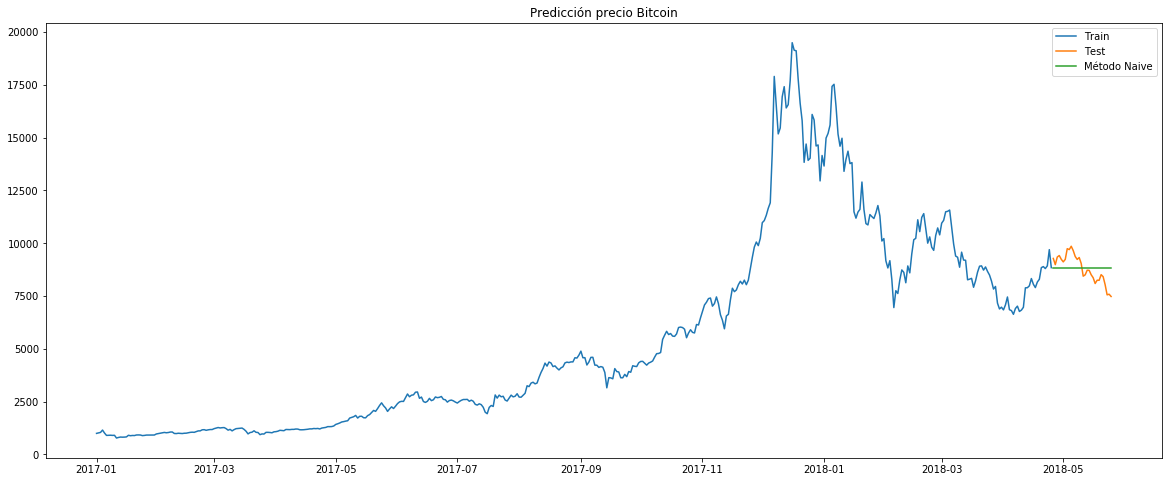

RMSE:659.8916969649894


In [12]:
training = np.asarray(train.bitcoin)
y_naive = test.copy()
y_naive['naive'] = training[len(training)-1]

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_naive.index, y_naive['naive'], label='Método Naive')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_naive.naive))
print("RMSE:" + str(rms))

Se puede ver por el RMSE y el gráfico, que el método no es adecuado para conjuntos de datos con alta variabilidad.

Método "Promedio simple": el precio del día siguiente es igual al promedio de los días previamente observados.

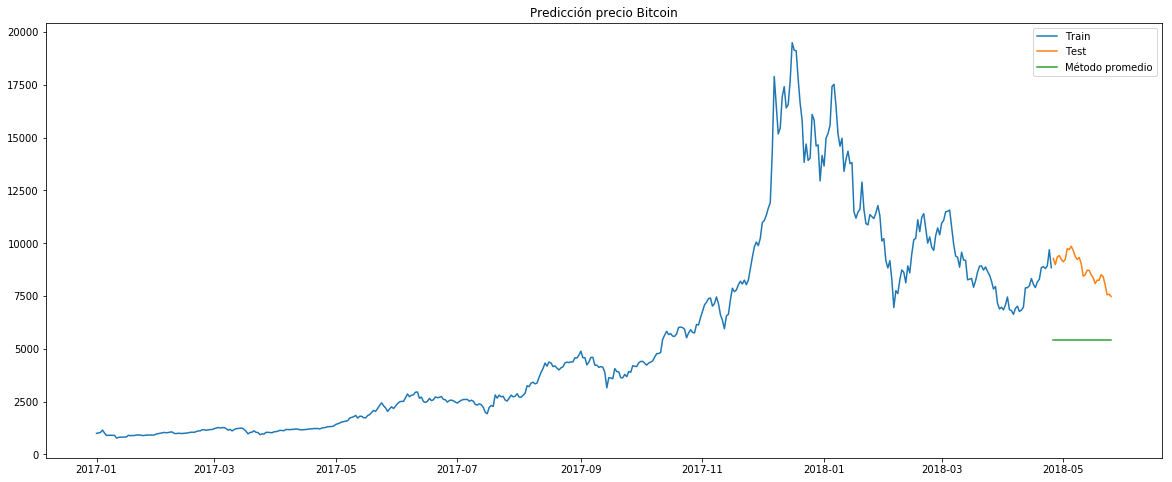

RMSE:3431.106549948896


In [13]:
training = np.asarray(train.bitcoin)
y_promedio = test.copy()
y_promedio['promedio'] = training.mean()

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_promedio.index, y_promedio['promedio'], label='Método promedio')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_promedio.promedio))
print("RMSE:" + str(rms))

El modelo no mejoró el RMSE. 

Método "Promedio móvil": es una mejora sobre el método de promedio simple, que toma solo el promedio de los precios en un período reciente (ventana)

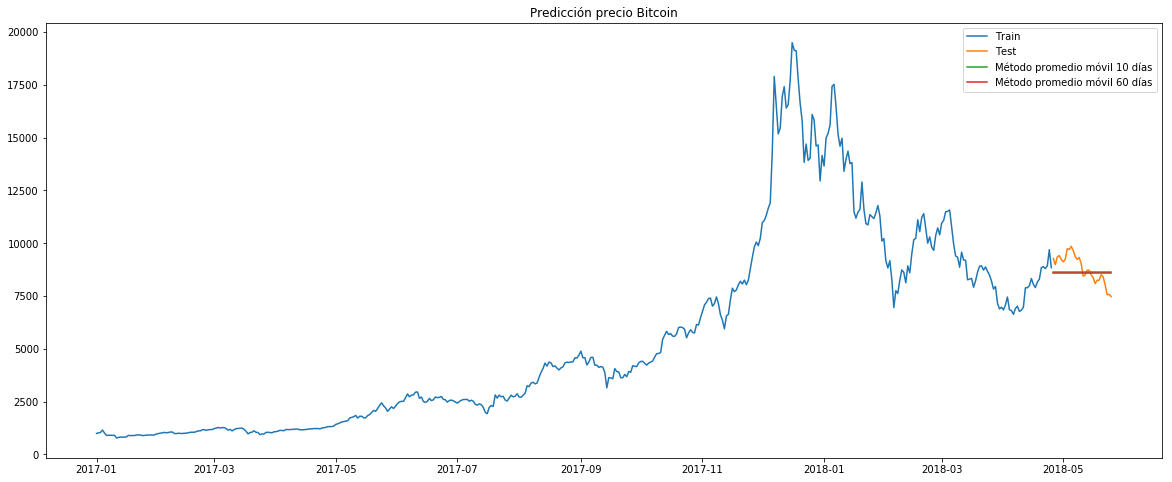

RMSE (10 días):676.8584031917871
RMSE (60 días):687.6099978713094


In [14]:
y_promedio_movil = test.copy()
y_promedio_movil['promedio_movil_10'] = train['bitcoin'].rolling(10).mean().iloc[-1]
y_promedio_movil['promedio_movil_60'] = train['bitcoin'].rolling(60).mean().iloc[-1]

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_promedio_movil.index, y_promedio_movil['promedio_movil_10'], label='Método promedio móvil 10 días')
plt.plot(y_promedio_movil.index, y_promedio_movil['promedio_movil_60'], label='Método promedio móvil 60 días')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_promedio_movil.promedio_movil_10))
print("RMSE (10 días):" + str(rms))
rms = sqrt(mean_squared_error(test.bitcoin, y_promedio_movil.promedio_movil_60))
print("RMSE (60 días):" + str(rms))

Se puede ver que hasta ahora el método "naive" es el que mejor ajusta para este conjunto de datos.
Un mejor acercamiento sería darle un peso a cada observación, para que las más cercanas en el tiempo influyan más en el promedio que las más lejanas.

Método "Suavizamiento Exponencial Simple": cada observación utilizada en el promedio tiene un peso asociado que decrementa exponencialmente a medida que se aleja en el tiempo (las observaciones más viejas tienen los pesos más pequeños). Modificando el factor "alfa" en la fórmula se ajusta el promedio y el error en la prediccion.

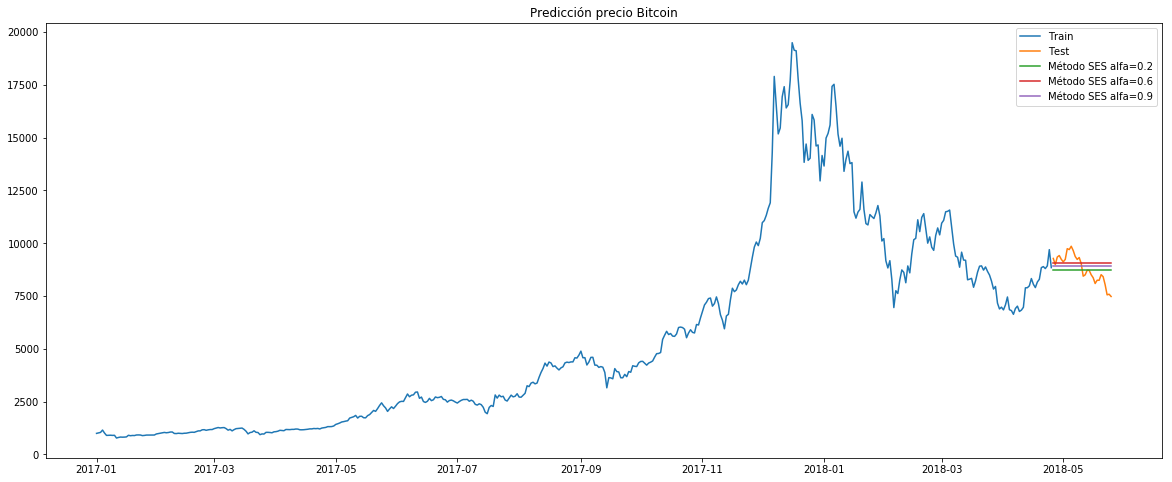

RMSE (alfa=0.2):660.3038982031388
RMSE (alfa=0.6):705.6726201105944
RMSE (alfa=0.9):669.6273584885415


In [15]:
y_SES = test.copy()
ses02 = SimpleExpSmoothing(np.asarray(train['bitcoin'])).fit(smoothing_level=0.2,optimized=False)
ses06 = SimpleExpSmoothing(np.asarray(train['bitcoin'])).fit(smoothing_level=0.6,optimized=False)
ses09 = SimpleExpSmoothing(np.asarray(train['bitcoin'])).fit(smoothing_level=0.9,optimized=False)
y_SES['SES_02'] = ses02.forecast(len(test))
y_SES['SES_06'] = ses06.forecast(len(test))
y_SES['SES_09'] = ses09.forecast(len(test))

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_SES.index, y_SES['SES_02'], label='Método SES alfa=0.2')
plt.plot(y_SES.index, y_SES['SES_06'], label='Método SES alfa=0.6')
plt.plot(y_SES.index, y_SES['SES_09'], label='Método SES alfa=0.9')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_SES.SES_02))
print("RMSE (alfa=0.2):" + str(rms))
rms = sqrt(mean_squared_error(test.bitcoin, y_SES.SES_06))
print("RMSE (alfa=0.6):" + str(rms))
rms = sqrt(mean_squared_error(test.bitcoin, y_SES.SES_09))
print("RMSE (alfa=0.9):" + str(rms))

Se puede ver que el mejor resultado lo da alfa=0.2. Sin embargo no se mejora el error del método "naive".
En general, estos métodos no funcionan bien para conjuntos de datos con mucha variabilidad.
Para conjuntos de datos que siguen una tendencia, es decir, que tienen un patrón general de movimiento de subida o de bajada (como en este caso), se puede usar el método de "Tendencia Lineal de Holt": es una extensión del método de suavizamiento exponencial simple aplicado al promedio de la serie ("nivel") y a la tendencia. La ecuación de nivel y la de tendencia se suman para general la ecuación de predicción. La suma es apropiada para conjuntos de datos con una tendencia que incrementa o decrementa linealmente, aunque también se puede usar la multiplicación de las ecuaciones de nivel y tendencia si el conjunto de datos muestra una tendencia exponencial. Se compararán los dos métodos.

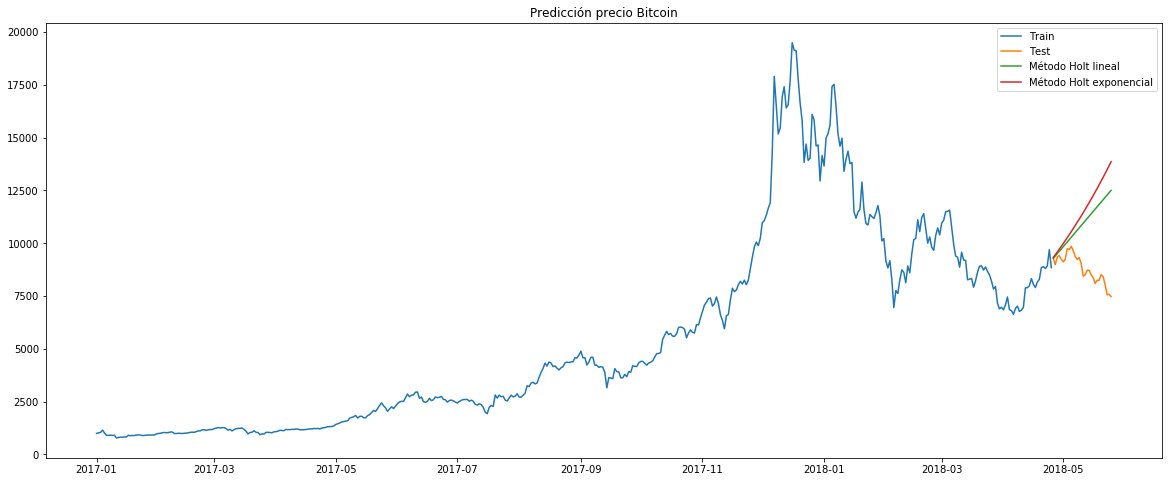

RMSE (Holt lineal):2612.8940183467607
RMSE (Holt exponencial):3290.2025411547347


In [16]:
y_holt = test.copy()
holt_lineal = Holt(np.asarray(train['bitcoin'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
holt_exp = Holt(np.asarray(train['bitcoin']), exponential=True).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_holt['holt_lineal'] = holt_lineal.forecast(len(test))
y_holt['holt_exp'] = holt_exp.forecast(len(test))

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_holt.index, y_holt['holt_lineal'], label='Método Holt lineal')
plt.plot(y_holt.index, y_holt['holt_exp'], label='Método Holt exponencial')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_holt.holt_lineal))
print("RMSE (Holt lineal):" + str(rms))
rms = sqrt(mean_squared_error(test.bitcoin, y_holt.holt_exp))
print("RMSE (Holt exponencial):" + str(rms))

Se puede ver que este método no sirve para este conjunto de datos ya que la tendencia cambia con frecuencia, no sigue un patrón.
Se puede intentar el método de Holt-Winter, que toma en cuenta la temporada en el cálculo (por ej. las visitas a un hotel en la playa van a ser influenciadas por la estación del año).
A las ecuaciones de nivel y de tendencia, se suma la ecuación de estacionalidad. Como en el método de Holt, las ecuaciones pueden sumarse o multiplicarse, prefiriendo la multiplicación cuando las variaciones estacionales cambian con el nivel de la serie (en este caso parece ser así).

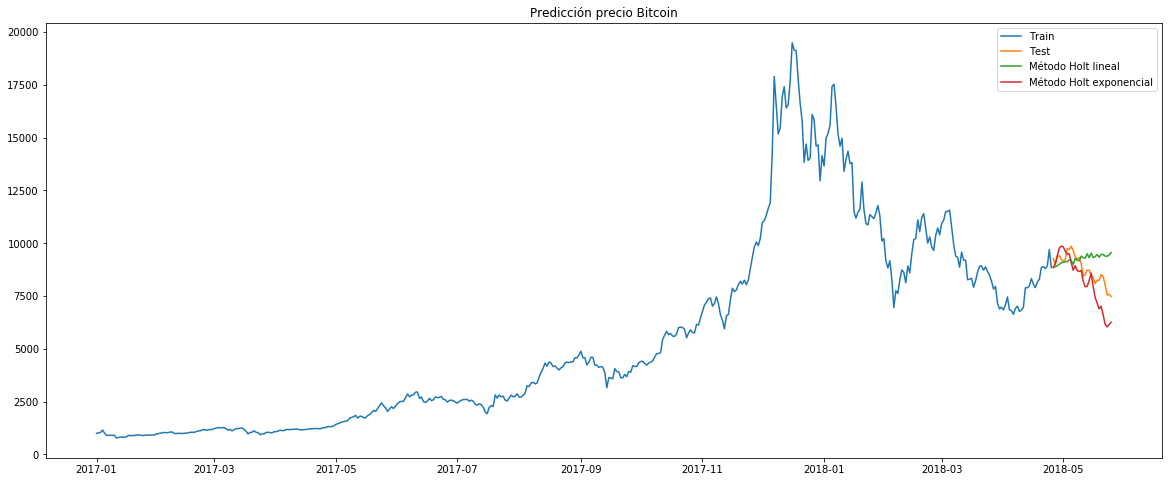

RMSE (Holt lineal):925.9711895557155
RMSE (Holt exponencial):887.0692678802034


In [17]:
y_holtwinters = test.copy()
holt_lineal = ExponentialSmoothing(np.asarray(train['bitcoin']) ,seasonal_periods=45 ,trend='add', seasonal='add',).fit()
holt_exp = ExponentialSmoothing(np.asarray(train['bitcoin']) ,seasonal_periods=45 ,trend='mul', seasonal='mul',).fit()
y_holtwinters['holt_lineal'] = holt_lineal.forecast(len(test))
y_holtwinters['holt_exp'] = holt_exp.forecast(len(test))

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_holtwinters.index, y_holtwinters['holt_lineal'], label='Método Holt lineal')
plt.plot(y_holtwinters.index, y_holtwinters['holt_exp'], label='Método Holt exponencial')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_holtwinters.holt_lineal))
print("RMSE (Holt lineal):" + str(rms))
rms = sqrt(mean_squared_error(test.bitcoin, y_holtwinters.holt_exp))
print("RMSE (Holt exponencial):" + str(rms))

Se eligió seasonal_periods=45 porque se puede notar que las tendencias se repiten más o menos cada 45 días. Se puede ver que este método mejora mucho el anterior. 
Aunque el RMSE sigue siendo más alto que el método naive, se puede ver que la curva de predicción del método Holt exponencial se aproxima mucho más a la curva real, y esto puede resultar mucho más significativo para predecir el movimiento del precio. 

Se probará el modelo ARIMA (Autoregressive Integrated Moving Average): intenta describir la correlación entre los datos y encontrar patrones para una predicción hacia el futuro. El método puede mejorarse utilizando estacionalidad: Seasonal ARIMA. 

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


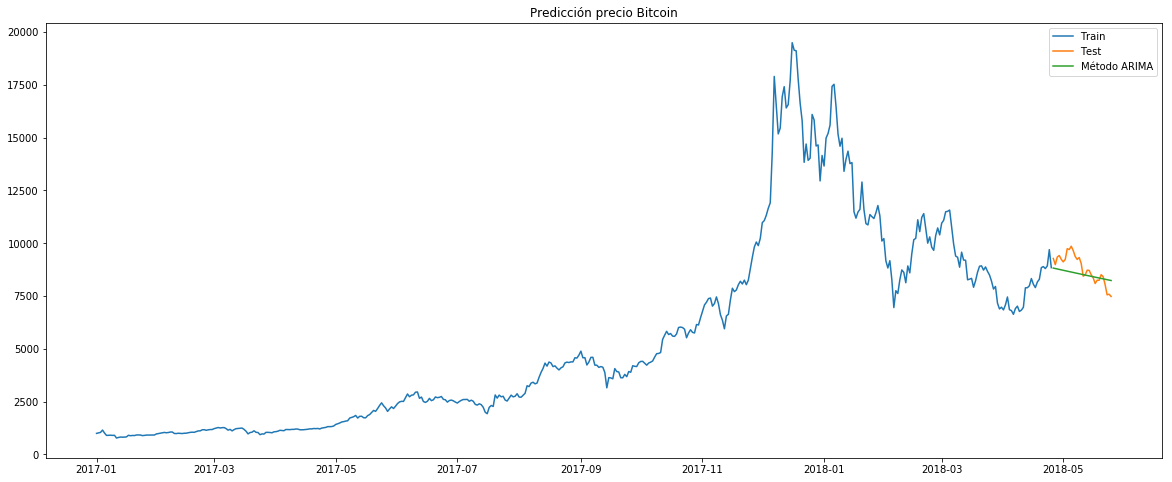

RMSE (ARIMA):584.9502934895916


In [18]:
y_ARIMA = test.copy()
arima = sm.tsa.statespace.SARIMAX(train['bitcoin']).fit()
y_ARIMA['arima'] = arima.predict(start="2018-04-26", end="2018-05-25", dynamic=True)

plt.figure(figsize=(20,8))
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_ARIMA.index, y_ARIMA['arima'], label='Método ARIMA')
plt.legend(loc='best')
plt.title("Predicción precio Bitcoin")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_ARIMA.arima))
print("RMSE (ARIMA):" + str(rms))

Se concluye entonces que el método ARIMA es el que menor error consigue, mientras que el método Holt-Winters multiplicativo es el que mejor ajusta la curva de predicción a la curva real.